### Data from the World Bank contains four variables
`- Country` <br>
 `- Year` – from 2000 to 2015 <br>
 `- Status` – developed / developing <br>
 `- Life Expectancy at Birth` – abbreviated as LEB for convenience <br>
 `- Adult Mortality, 'Infant deaths', 'Under Five Deaths' `(all per 1000 people)`, 'Alcohol', 'Hepatitis B', 'Measles', 'BMI', 'Polio', 'Diphtheria', 'HIV/AIDS'` – medical statistics for each country each year<br>
 `- Population, GDP`* – could be useful, but not for the scope of this project. <br>
 `- Income composition of resources` – how effeicient the resources are used (supposed to have the highest positive correlation with the LED variable) <br>
 `- Schooling` - years of schooling <br>
 
`*` If we take a look at the GDP column we'll find that the values are messed up. Some of them (regardless of the Year variable) has a unit of billion, others are in ten billion, a hundred million, etc.

### Steps of the project

- Clean up the dataset.

- Analyze changes in LEB for 15 years.

    - LEB changes for 15 years in developing and developed nations
    - Show correlation table and scatter plots with the LEB variable.
    
- Report what was done throughout the project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
df = pd.read_csv('Life Expectancy Data.csv')

### Processing

##### Take a look at the columns

In [3]:
# Display all the columns
pd.set_option('display.max_columns', len(df.columns))

In [4]:
df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

In [5]:
df.shape

(2938, 22)

The column names need to be fixed as they have whitespaces at the string ends and different cases
##### Fixing column names (using snake case)

In [6]:
# Strip the whitespaces in the column names
df.columns = [x.strip() for x in df.columns]

In [7]:
# After getting rid of the NaN values, we can safely change the column names
df.columns = [x.lower() for x in df.columns]
df.columns = [x.replace(' ', '_').replace('-', '_').replace('/', '_') for x in df.columns]

In [8]:
# Displaying the column names once again
df.columns

Index(['country', 'year', 'status', 'life_expectancy', 'adult_mortality',
       'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b',
       'measles', 'bmi', 'under_five_deaths', 'polio', 'total_expenditure',
       'diphtheria', 'hiv_aids', 'gdp', 'population', 'thinness__1_19_years',
       'thinness_5_9_years', 'income_composition_of_resources', 'schooling'],
      dtype='object')

##### Drop unnecessary columns

In [9]:
df = df.drop(columns=['percentage_expenditure', 'total_expenditure', 'thinness__1_19_years',
       'thinness_5_9_years', 'gdp', 'population'])

##### Deal with missing values

In [10]:
# Looking for NaN values
leb_nan = df['life_expectancy'].isna()
df.loc[leb_nan]

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,hepatitis_b,measles,bmi,under_five_deaths,polio,diphtheria,hiv_aids,income_composition_of_resources,schooling
624,Cook Islands,2013,Developing,NaN,NaN,0,0.01,98.0,0,82.8,0,98.0,98.0,0.1,NaN,NaN
769,Dominica,2013,Developing,NaN,NaN,0,0.01,96.0,0,58.4,0,96.0,96.0,0.1,0.721,12.7
1650,Marshall Islands,2013,Developing,NaN,NaN,0,0.01,8.0,0,81.6,0,79.0,79.0,0.1,NaN,0.0
1715,Monaco,2013,Developing,NaN,NaN,0,0.01,99.0,0,NaN,0,99.0,99.0,0.1,NaN,NaN
1812,Nauru,2013,Developing,NaN,NaN,0,0.01,87.0,0,87.3,0,87.0,87.0,0.1,NaN,9.6
1909,Niue,2013,Developing,NaN,NaN,0,0.01,99.0,0,77.3,0,99.0,99.0,0.1,NaN,NaN
1958,Palau,2013,Developing,NaN,NaN,0,NaN,99.0,0,83.3,0,99.0,99.0,0.1,0.779,14.2
2167,Saint Kitts and Nevis,2013,Developing,NaN,NaN,0,8.54,97.0,0,5.2,0,96.0,96.0,0.1,0.749,13.4
2216,San Marino,2013,Developing,NaN,NaN,0,0.01,69.0,0,NaN,0,69.0,69.0,0.1,NaN,15.1
2713,Tuvalu,2013,Developing,NaN,NaN,0,0.01,9.0,0,79.3,0,9.0,9.0,0.1,NaN,0.0


We'll delete all the rows with missing values in the Life Expectancy column, because this variable is crucial for the analysis.

In [11]:
df = df.dropna(subset=['life_expectancy'])

For the rest of the columns we'll fill the NaN values with variable means depending on the Status parameter (whether a country is developed or developing according to the World Bank).

In [12]:
df.isna().sum()

country                              0
year                                 0
status                               0
life_expectancy                      0
adult_mortality                      0
infant_deaths                        0
alcohol                            193
hepatitis_b                        553
measles                              0
bmi                                 32
under_five_deaths                    0
polio                               19
diphtheria                          19
hiv_aids                             0
income_composition_of_resources    160
schooling                          160
dtype: int64

### Create two datesets for two types of nations (based on the Status column) to analyze them separetely (and to concatenate them later).

In [13]:
developed = df.loc[df.status == 'Developed']
developing = df.loc[df.status == 'Developing']

In [14]:
# Split both dataset by those with and without missing values
developed_miss = developed.loc[:, developed.isnull().any()]
developing_miss = developing.loc[:, developing.isnull().any()]

In [15]:
# Drop the columns with missing values
developed = developed.drop(columns=developed_miss.columns)
developing = developing.drop(columns=developing_miss.columns)

In [16]:
# Fill in the missing values with multiple imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=len(developed_miss), random_state=0)
imp.fit(developed_miss)
developed_miss_filled = pd.DataFrame(np.round(imp.transform(developed_miss),1), columns=developed_miss.columns)

In [17]:
imp = IterativeImputer(max_iter=len(developing_miss), random_state=0)
imp.fit(developing_miss)
developing_miss_filled = pd.DataFrame(np.round(imp.transform(developing_miss),1), columns=developing_miss.columns)

In [18]:
# Just make sure, the two yet-to-be-merged datasets have the same lenth
print(len(developed_miss_filled), len(developed))
print(len(developing_miss_filled), len(developing))

512 512
2416 2416


##### Concatenate/merge all four DataFrames

In [19]:
# developed and developed_miss_filled
developed[developed_miss_filled.columns] = developed_miss_filled.values

In [20]:
# developing and developing_miss_filled
developing[developing_miss_filled.columns] = developing_miss_filled.values

In [21]:
# developed and developing
countries = pd.concat([developed, developing])
countries = countries.sort_values(by='country').reset_index(drop=True)

In [22]:
# Taking a look at the final dataset
countries.sample(10)

,country,year,status,life_expectancy,adult_mortality,infant_deaths,measles,bmi,under_five_deaths,polio,diphtheria,hiv_aids,alcohol,hepatitis_b,income_composition_of_resources,schooling
846,Equatorial Guinea,2000,Developing,52.7,336.0,3,0,18.3,4,41.0,34.0,1.9,4.5,37.5,0.0,0.0
1776,Myanmar,2001,Developing,62.5,239.0,72,2519,14.1,98,77.0,73.0,0.4,0.4,71.9,0.4,7.6
1719,Mongolia,2009,Developing,66.9,235.0,1,8,45.9,2,96.0,95.0,0.1,4.6,97.0,0.7,13.8
2540,Syrian Arab Republic,2002,Developing,72.8,135.0,9,538,45.3,11,86.0,84.0,0.1,1.2,8.0,0.6,10.2
2013,Peru,2012,Developing,74.9,129.0,9,0,53.6,11,94.0,95.0,0.1,5.1,95.0,0.7,13.4
714,Democratic People's Republic of Korea,2011,Developing,69.4,153.0,8,0,3.8,10,99.0,94.0,0.1,3.4,94.0,0.5,9.9
704,Democratic People's Republic of Korea,2001,Developing,66.6,177.0,16,0,25.7,21,98.0,62.0,0.1,2.5,70.0,0.5,10.2
2160,Saint Lucia,2000,Developing,71.6,183.0,0,0,36.8,0,7.0,7.0,0.4,11.7,15.3,0.0,12.8
2028,Philippines,2012,Developing,68.1,217.0,56,1536,23.7,71,88.0,88.0,0.1,5.0,88.0,0.7,11.6
2760,United Kingdom of Great Britain and Northern I...,2006,Developed,79.3,82.0,4,764,61.3,4,92.0,92.0,0.1,11.6,87.4,0.8,15.8


In [23]:
# Making sure there are no NaN values left
countries.isna().sum()

country                            0
year                               0
status                             0
life_expectancy                    0
adult_mortality                    0
infant_deaths                      0
measles                            0
bmi                                0
under_five_deaths                  0
polio                              0
diphtheria                         0
hiv_aids                           0
alcohol                            0
hepatitis_b                        0
income_composition_of_resources    0
schooling                          0
dtype: int64

In [24]:
# Looking at the data types
countries['status'] = pd.Categorical(countries['status'], list(countries['status'].unique()))
countries.dtypes

country                              object
year                                  int64
status                             category
life_expectancy                     float64
adult_mortality                     float64
infant_deaths                         int64
measles                               int64
bmi                                 float64
under_five_deaths                     int64
polio                               float64
diphtheria                          float64
hiv_aids                            float64
alcohol                             float64
hepatitis_b                         float64
income_composition_of_resources     float64
schooling                           float64
dtype: object

### Analysis
#### LEB changes for 15 years in the developing and developed nations.

In [25]:
years = list(countries.year.unique())

leb_by_year_developed = developed.groupby(['year']).life_expectancy.mean()
leb_by_year_developing = developing.groupby(['year']).life_expectancy.mean()

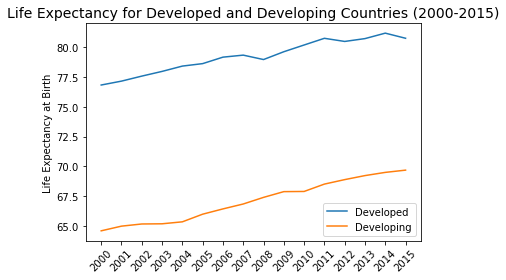

In [26]:
plt.plot(leb_by_year_developed, label='Developed')
plt.plot(leb_by_year_developing, label='Developing')

plt.legend(loc=4)
plt.xticks(years, rotation=45)
plt.title('Life Expectancy for Developed and Developing Countries (2000-2015)', fontsize=14)
plt.ylabel('Life Expectancy at Birth')
plt.show()

#### Correlation of life expectancy with other variables.

In [27]:
def led_stats_corr(i, y_col):
    plt.subplot(2, 2, i)
    ax = sns.scatterplot(data = countries, x = 'life_expectancy', y = y_col, hue = 'status', s = 20)
    y_string = y_col.replace('_', ' ').title()
    plt.title(f'Life Expectancy vs {y_string}', fontsize=14)
    return ax

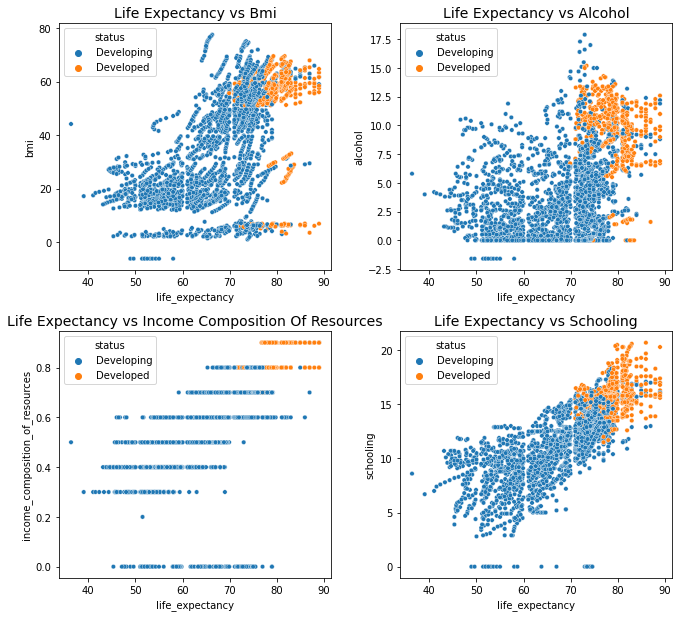

In [28]:
plt.rcParams['figure.figsize'] = [11, 7]

# Scatterplot life_expectancy and bmi
led_stats_corr(1, 'bmi')

# Scatterplot life_expectancy and alcohol
led_stats_corr(2, 'alcohol')

# Scatterplot life_expectancy and income_composition_of_resources
led_stats_corr(3, 'income_composition_of_resources')

# Scatterplot life expectancy and schooling
led_stats_corr(4, 'schooling')

plt.subplots_adjust(wspace=0.25, hspace=0.25, top=1.3, bottom=0.2)
plt.show()

Based on these graphs, we see a possitive correlation between life expectancy with Income Composition of Resources and Schooling. <br>
There is a slight possitive correlation with alcohol and, especially, BMI, but it doesn't mean that people who consume more alcohol or have higher BMI tend to live longer in general.

In [29]:
# Calculating Pearson correlation for these variables

cols_for_corr = ['life_expectancy', 'bmi', 'alcohol', 'income_composition_of_resources', 'schooling']
countries[cols_for_corr].corr().iloc[0]

life_expectancy                    1.000000
bmi                                0.576485
alcohol                            0.419462
income_composition_of_resources    0.722415
schooling                          0.754713
Name: life_expectancy, dtype: float64

#### Distributution of other variables every year
Here, we'll build a function to display the distribution of data for a given period of time. <br> `Due to the huge difference in some statistic between developed and developing countries, log transformation can be applied, optionally.`

In [30]:
def dist_by_year(year, col_list, log_needed):
    """
    year – plot data for a given year (int)
    col_list - list of columns to plot (list of strings)
    log_needed - list of Boolean values; every value's index corresponds to col_list index
    """
    this_year = countries[countries['year'] == year]
    subplot_num = len(col_list)
    
    for i in range(1, subplot_num+1):
        x_col_string = col_list[i-1].replace('_', ' ').title()
        
        if log_needed[i-1] == False:
            sns.displot(x=this_year[col_list[i-1]], hue=this_year['status'], kind="kde")
            plt.title(f"{x_col_string} Rate for Developing and Developed Countries in {year}")
            plt.xlabel(f"{x_col_string} Rate")
        else:
            sns.displot(x=np.log(this_year[col_list[i-1]]), hue=this_year.status, kind="kde")
            plt.title(f"{x_col_string} Rate for Developing and Developed Countries in {year} – log scaled")
            plt.xlabel(f"{x_col_string} Rate (log scaled)")
        
        plt.ylabel("")
        plt.show()
        plt.clf()

###### Test the function
###### i. Adult mortality, infant and under five year old deaths `(log transform the last two)` for the years 2000 and 2015. 

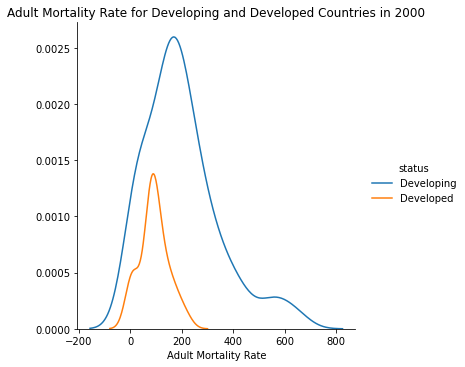

C:\Users\jrank\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 792x504 with 0 Axes>

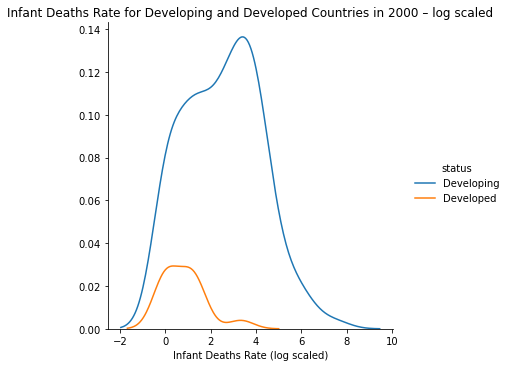

C:\Users\jrank\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 792x504 with 0 Axes>

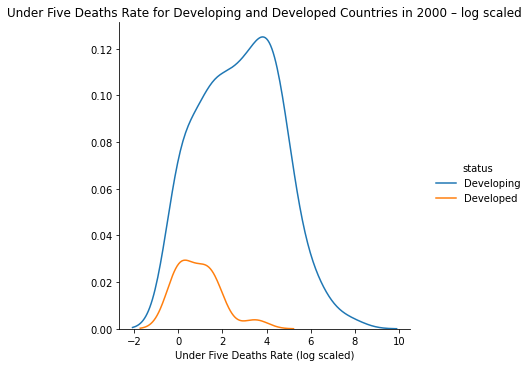

<Figure size 792x504 with 0 Axes>

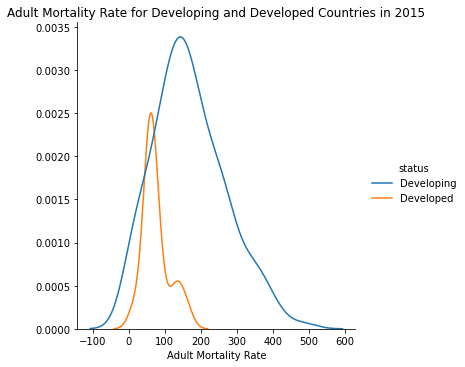

C:\Users\jrank\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 792x504 with 0 Axes>

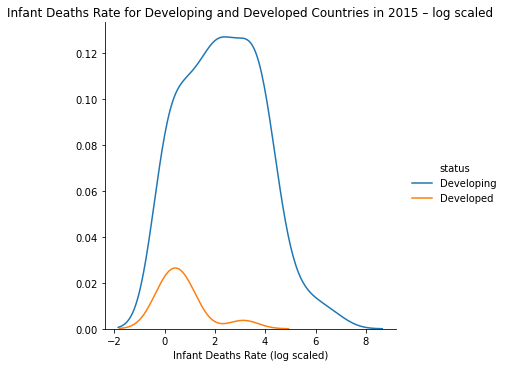

C:\Users\jrank\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Figure size 792x504 with 0 Axes>

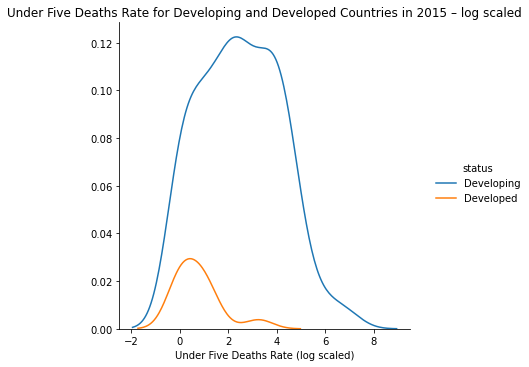

<Figure size 792x504 with 0 Axes>

In [31]:
years = [2000, 2015]
for year in years:
    dist_by_year(year, ['adult_mortality', 'infant_deaths', 'under_five_deaths'], [False, True, True])

###### ii. Measles, polio, diphtheria, hepatitis B distribution for the year 2015

C:\Users\jrank\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


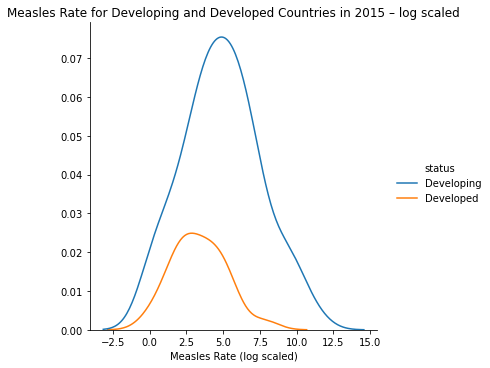

<Figure size 792x504 with 0 Axes>

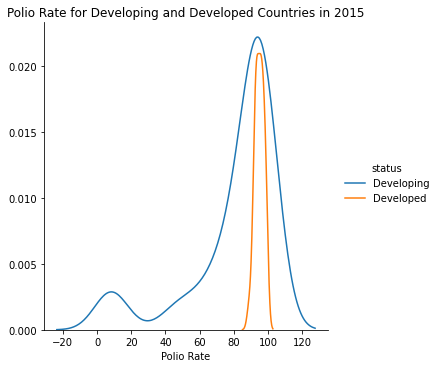

<Figure size 792x504 with 0 Axes>

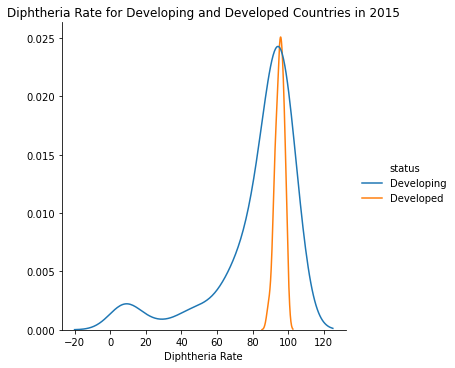

<Figure size 792x504 with 0 Axes>

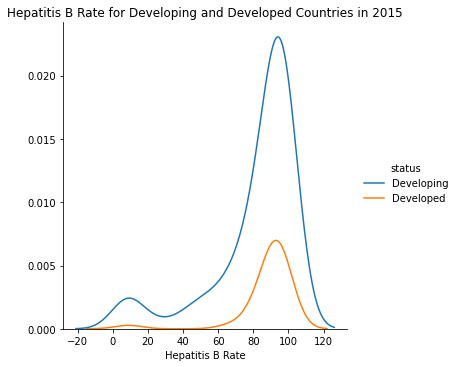

<Figure size 792x504 with 0 Axes>

In [32]:
dist_by_year(2015, ['measles', 'polio', 'diphtheria', 'hepatitis_b'], [True, False, False, False])

#### Conclusion

What was done throughout the process.

1. Fixed names of the columns.<br>
```
df.columns = [x.strip() for x in df.columns]
df.columns = [x.lower() for x in df.columns]
df.columns = [x.replace(' ', '_') for x in df.columns]
```


2. I selected columns with missing values. <br>
```
developed_miss = developed.loc[:, developed.isnull().any()]
```


3. First I diplayed the amount of missing values in every column<br>
```
df.isna().sum()
```


4. Then I split the dataset by two in order to fill the NaN with the most appropriate values (because every medical parameter is drastically different.<br>
```
developed = df.loc[df.status == 'Developed']
```


5. And then split each by two again to provide the IterativeImputer from the sklearn library only with the columns with missing values.<br>
```
developed_miss = developed.loc[:, developed.isnull().any()]
```


6. 'Concatinated' two DataFrames with different columns and indices, but the same length by adding columns from one DF to another with a simple assigning. <br>
```
developed[developed_miss_filled.columns] = developed_miss_filled.values
```

    Then I concatinated the developed and developing DataFrames, and got the original table, but with appropriately filled missing values and without rows with NaN in the GDP and Life Expectancy columns (due to their importance for the following analysis).
    
    ```
    countries = pd.concat([developed, developing])
    countries = countries.sort_values(by='country').reset_index(drop=True)
    ```

7. I made a few graphs on life expectancy growths in 2000 - 2015 and correlation between life expectancy with the alcohol consumption, BMI, schooling years, and income composition of resources. All these parameters have positive correlation with life expectancy, though it doesn't tell anything about causation.


8. Finally, I showed the distribution of other statisctics. First, I tested the function with the mortality variables (adults, infants, and under five year old children) for the first and the last years in the data set. In order to display the infants and children mortality on the graph, I applied logarithmic transormation. <br> Second, I tried out the function with the diseases which still affect children all over the world (measles, polio, diphtheria, hepatitis B).)

For the steps 7 and 8, I custom functions to visualize all the required data efficiently. <br> The first function takes in a counter for subplots and a column name to build a scatterplot. <br> The second function takes in a year, list of columns, and list of Boolean of the same lenth to tell whether a log transformation should be applied to the plot.